# Face Masks Detection

## Introduction

A problem often occurring nowadays is people not wearing their Covid19 masks correctly (or not
at all). Since this is one of the few means to prevent the spread of the pandemic, it is important
to wear the masks properly. 

This project aims at classifying pictures of people into three classes:
 - correct use of mask
 - incorrect use of mask
 - no mask at all

## Dataset

You can find the dataset of 853 images on Kaggle [1](https://www.kaggle.com/andrewmvd/face-mask-detection). The data contains images with people
wearing masks correctly, incorrectly or not wearing masks at all. Additionally, the images are
annotated with bounding boxes describing the position of the mask.

## Mission

__The final objective is to classify an image into the three classes “correct use of mask”,
“incorrect use of mask”, “no mask at all”.__

For this, the following tasks need to be accomplished:
+ Understand the content that is available in the dataset (EDA)
+ Pre-process the data. Since there are less than 1000 images you might need to augment the data.
    - Additionally, you can try to find more (public) data, but first try to work with the images provided.
+ Build a “traditional” (non-neural) model and a neural model to classify the images.
    - Compare the performance of both models. Which one is better and why?
    - Which one gets better when you augment the data?
+ Analyze the errors the better model made. Where did it have problems? Can you find error classes, that is, can you group the misclassified images in any way?
+ Visualize the results with the techniques you learned during your lectures.

# Python imports

In [ ]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xml.dom.minidom
import tensorflow as tf
import pandas as pd
import re
import seaborn as sns

from PIL import Image, ImageShow, ImageDraw
from xml.dom.minidom import parse
from sklearn.metrics import classification_report

# Exploratory Data Analysis

Dataset is available on Kaggle site. An `archive.zip` file can be downloaded.

The file contains two sub-directories:
 * `archive/annotations`
 * `archive/images`

## Images

The images are in `.png` bitmap format. Annotations are in `XML` format.

In [ ]:
# Setting up directory vars
image_dir = "archive/images/"
annot_dir = "archive/annotations/"

In [ ]:
images = os.listdir(image_dir)
images.sort()

print(f"There are {len(images)} files in {image_dir}:")
print(f"Preview:")
print(images[0:5])

print()

annots = os.listdir(annot_dir)
annots.sort()

print(f"There are {len(annots)} files in {annot_dir}:")
print(f"Preview:")
print(annots[:5])

There are 853 files in archive/images/:
Preview:
['maksssksksss0.png', 'maksssksksss1.png', 'maksssksksss10.png', 'maksssksksss100.png', 'maksssksksss101.png']

There are 853 files in archive/annotations/:
Preview:
['maksssksksss0.xml', 'maksssksksss1.xml', 'maksssksksss10.xml', 'maksssksksss100.xml', 'maksssksksss101.xml']


The file names are following convention:  
`maksssksksssN.(png|xml)`

N = image number  
(png|xml) = file format extensions

There are 853 images and annotations available.

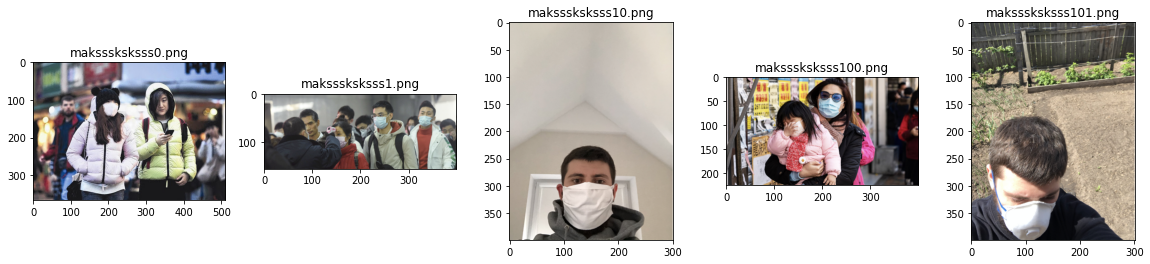

In [ ]:
# Let's preview couple of images

fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(5*4, 4))

for index, image_file in enumerate(images[0:5]):
    with open(image_dir + image_file, "rb") as file:
        image = Image.open(file)
        axs[index].set_title(image_file)
        axs[index].imshow(image)
        
plt.show()

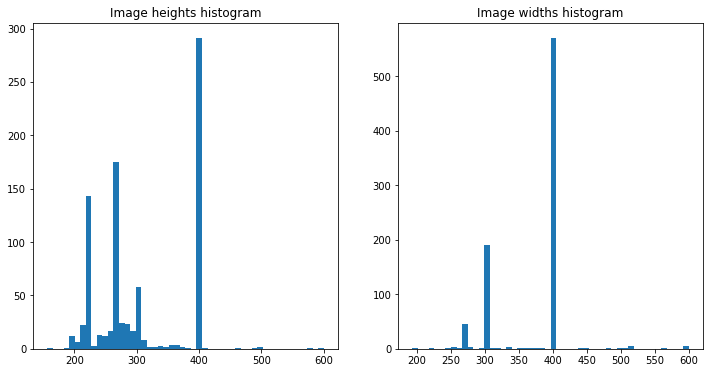

In [ ]:
image_heights = []
image_widths  = []

for index, image_file in enumerate(images):
    with open(image_dir + image_file, "rb") as file:
        image = Image.open(file)
        image_heights.append(image.height)
        image_widths.append(image.width)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2*6, 6))

axs[0].hist(image_heights, bins=50)
axs[0].set_title("Image heights histogram")
axs[1].hist(image_widths, bins=50)
axs[1].set_title("Image widths histogram")

plt.show()



In [ ]:
def display_image_regions(image_path, annot_path):
    """ Display given image file and draw regions from its annotation.
    """
    with open(image_path, "rb") as file:
        image = Image.open(file)
        
        with open(annot_path, "rb") as file:

            # Parses XML document
            document = xml.dom.minidom.parse(file)

            # Gets root element of the document
            # doc_element = document.documentElement

            # Get list of regions (several of them)
            regions = document.getElementsByTagName("object")

            for index, region in enumerate(regions):

                # There is just one of each, so we can reference with [0].firstChild
                target = region.getElementsByTagName("name")[0].firstChild.data
                xmin   = int(region.getElementsByTagName("xmin")[0].firstChild.data)
                ymin   = int(region.getElementsByTagName("ymin")[0].firstChild.data)
                xmax   = int(region.getElementsByTagName("xmax")[0].firstChild.data)
                ymax   = int(region.getElementsByTagName("ymax")[0].firstChild.data)
                
                print(f"Box[{index}] = [{xmin}, {ymin}, {xmax}, {ymax}]\tTarget[{index}] = {target}")

                # Now we'll draw the regions on the image
                image_draw = ImageDraw.Draw(image)
                image_draw.rectangle([(xmin, ymin), (xmax, ymax)], outline="red")

                # And a number inside
                image_draw.text(
                    (int((xmin+xmax)/2), int((ymin+ymax)/2)),
                    str(index),
                    fill ="red"
                    )

        image.show()


Box[0] = [321, 34, 354, 69]	Target[0] = with_mask
Box[1] = [224, 38, 261, 73]	Target[1] = with_mask
Box[2] = [299, 58, 315, 81]	Target[2] = with_mask
Box[3] = [143, 74, 174, 115]	Target[3] = with_mask
Box[4] = [74, 69, 95, 99]	Target[4] = with_mask
Box[5] = [191, 67, 221, 93]	Target[5] = with_mask
Box[6] = [21, 73, 44, 93]	Target[6] = with_mask
Box[7] = [369, 70, 398, 99]	Target[7] = with_mask
Box[8] = [83, 56, 111, 89]	Target[8] = without_mask


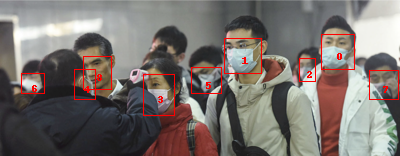

In [ ]:
display_image_regions(image_dir + "maksssksksss1.png", annot_dir + "maksssksksss1.xml")

# Faces extraction

All faces from the images have been cut out into a heap of 4072 small images. They were stored in directory `faces`.

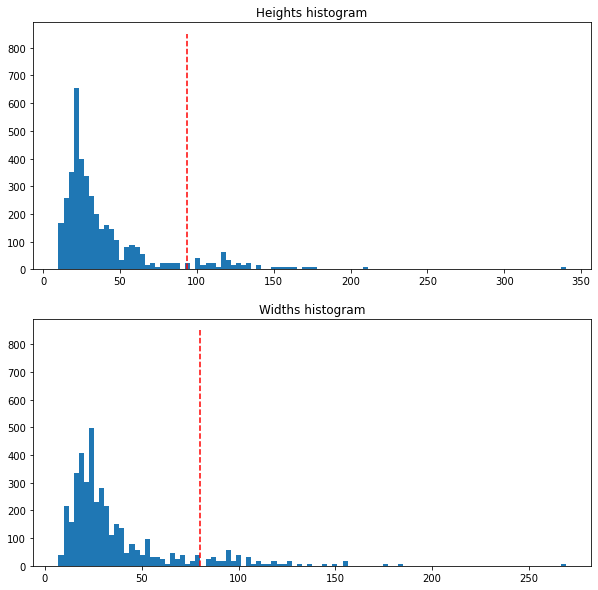

In [ ]:
heights = []
widths  = []

for file_name in os.listdir("faces_orig/"):

    with open("faces/" + file_name, "rb") as f:
        img = Image.open(f).convert("RGB")
        heights.append(img.height)
        widths.append(img.width)

h_cutoff = np.percentile(heights, 90)
w_cutoff = np.percentile(widths,  90)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

axs[0].hist(heights, bins=100)
axs[0].set_title("Heights histogram")
axs[0].vlines(h_cutoff, 0, 850, linestyles='dashed', label=f'cutoff = {h_cutoff}', color="red")
axs[1].hist(widths, bins=100)
axs[1].vlines(w_cutoff, 0, 850, linestyles='dashed', label=f'cutoff = {w_cutoff}', color="red")
axs[1].set_title("Widths histogram")

plt.show()        

In [ ]:
h_cutoff = np.percentile(heights, 95)
w_cutoff = np.percentile(widths,  95)

h_cutoff, w_cutoff

(120.0, 100.0)

In [ ]:
for index in range(4072):

    try:
        open(fac)

In [ ]:
count=0

for file_name in os.listdir("faces_orig/"):

    with open("faces_orig/" + file_name, "rb") as f:
        img = Image.open(f).convert("RGB")
        area.append(img.height * img.width)
        ratios.append(img.height / img.width)
    
    if (img.height * img.width) < 156:
        count += 1

print(count)



665


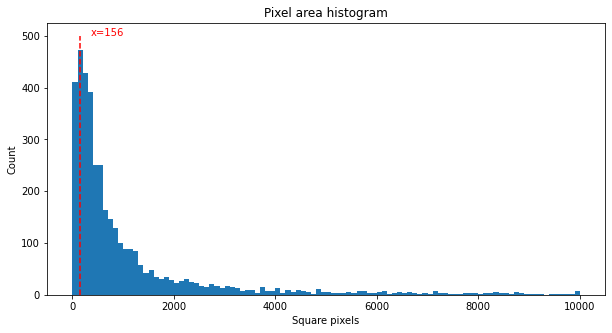

In [ ]:
area = []
ratios = []

for file_name in os.listdir("faces_orig/"):

    with open("faces_orig/" + file_name, "rb") as f:
        img = Image.open(f).convert("RGB")
        area.append(img.height * img.width)
        ratios.append(img.height / img.width)

area_cutoff = np.percentile(area, 15)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

axs.hist(area, bins=100, range=(0,10000))

axs.set_title("Pixel area histogram")
axs.vlines(156, 0, 500, linestyles='dashed', color="red")
axs.text(x=156+200, y=500, s=f"x=156", color="red")
axs.set_ylabel("Count")
axs.set_xlabel("Square pixels")


# axs[1].hist(ratios, bins=100)
# axs[1].set_title("Ratios histogram")

plt.show()        

In [ ]:
area[int(4072*0.05)]

63

In [ ]:
len(area)

4072

In [ ]:
area_cutoff = np.percentile(area, 5)

area_cutoff

63.0

# Pandas dataframe

In [ ]:
def split_label(line):
    """ Split line and return only label
    """
    line = line.split("\n")[0]
    index, label = line.split(":")
    return label

labels = []

# Getting only labels from the "labels.txt" - prepared by Laszlo
with open("labels.txt", "rt") as f:
    for line in f:
        labels.append(split_label(line))

In [ ]:
faces = []
index = []

for item in os.listdir("faces/"):
    result = re.search(r"([0-9]+)", item)
    faces.append(item)
    index.append(int(result.groups(1)[0]))

#for i in range(len(faces)):
    #print(index[i], faces[i])

In [ ]:
len(index), len(faces)

(29288, 29288)

In [ ]:
df = pd.DataFrame(data=faces, index=index)

In [ ]:
df.head(4)

,0
4700,im4700.png
24391,im24391.png
8767,im8767.png
16486,im16486.png


In [ ]:
df_labels = pd.DataFrame(data=labels)

In [ ]:
df_labels.head()

,0
0,without_mask
1,without_mask
2,without_mask
3,without_mask
4,without_mask


In [ ]:
df.head(4)

,0
4700,im4700.png
24391,im24391.png
8767,im8767.png
16486,im16486.png


In [ ]:
df = df.merge(df_labels, how="inner", left_index=True, right_index=True).rename(columns={"0_x":"filename", "0_y":"label"}).copy()

In [ ]:
df.sample(6)

,filename,label
10482,im10482.png,with_mask
15507,im15507.png,with_mask
25453,im25453.png,with_mask
22276,im22276.png,with_mask
8635,im8635.png,without_mask
21465,im21465.png,without_mask


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29288 entries, 4700 to 1641
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  29288 non-null  object
 1   label     29288 non-null  object
dtypes: object(2)
memory usage: 686.4+ KB


In [ ]:
df['label'].value_counts()

with_mask                23368
without_mask              4960
mask_weared_incorrect      960
Name: label, dtype: int64

In [ ]:
def show_image(df=df, index=0):
    path = df.loc[[index],["filename"]].head(1).values
    label = df.loc[[index],["label"]].head(1).values

    print(f"{path[0]} -> {label[0]}")
    
    with open("faces/" + str(path[0][0]), "rb") as f:
        img = Image.open(f)
        img.show()
    



['im6391.png'] -> ['mask_weared_incorrect']


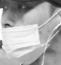

In [ ]:
show_image(index=6391) # super tiny this one  we have to pad them to 224 x 224

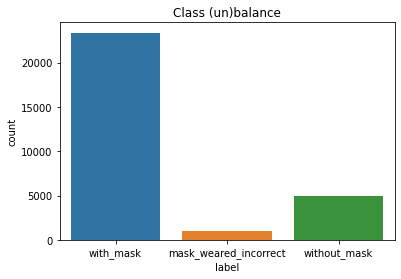

In [ ]:
ax = sns.countplot(x=df["label"])
ax.set_title("Class (un)balance")

plt.show()

In [ ]:
# This should shuffle entire dataframe
df = df.sample(frac=1).copy()

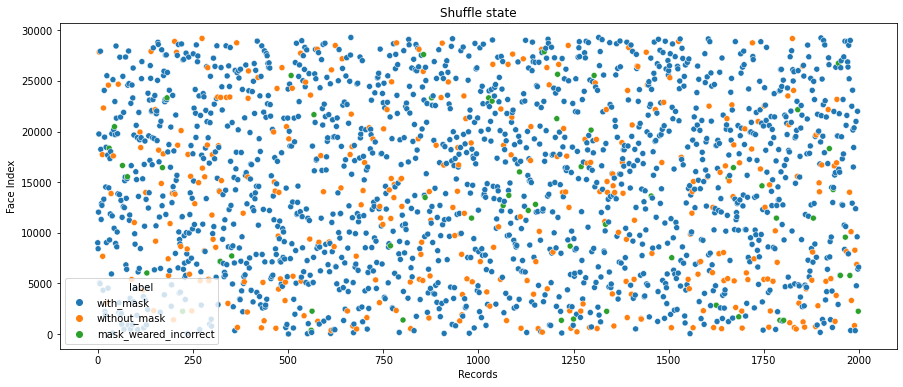

In [ ]:
# Seems random enough to me 
fig, ax = plt.subplots(figsize=(15,6))
ax = sns.scatterplot(x=range(2000), y=(df.index)[0:2000], hue="label", data=(df.head(2000)))
ax.set_title("Shuffle state")
ax.set_xlabel("Records")
ax.set_ylabel("Face Index")
plt.show()

In [ ]:
df["label"].value_counts()

with_mask                23368
without_mask              4960
mask_weared_incorrect      960
Name: label, dtype: int64

In [ ]:
# One-hot

for category in ["with_mask", "mask_weared_incorrect", "without_mask"]:
    df[category] = 0
    df.loc[df["label"]==category, category] = 1


In [ ]:
df.sample(15)

,filename,label,with_mask,mask_weared_incorrect,without_mask
8126,im8126.png,with_mask,1,0,0
8489,im8489.png,with_mask,1,0,0
14382,im14382.png,with_mask,1,0,0
27221,im27221.png,with_mask,1,0,0
889,im0889.png,with_mask,1,0,0
13160,im13160.png,mask_weared_incorrect,0,1,0
28259,im28259.png,with_mask,1,0,0
15951,im15951.png,with_mask,1,0,0
24810,im24810.png,with_mask,1,0,0
12051,im12051.png,with_mask,1,0,0


In [ ]:
df.shape

(29288, 5)

In [ ]:
labels = df[["with_mask", "mask_weared_incorrect", "without_mask"]].to_numpy()

In [ ]:
filenames = df["filename"].to_numpy()

In [ ]:
dataset_list = [(filename, label) for filename, label in zip(filenames, labels)]
    

In [ ]:
len(dataset_list)

29288

# Tensorflow Pipeline

We will try to prepare a tensorflow pipeline, i.e. ETL pipepline which will use `tf.data` API and will result in a `tf.data.Dataset` instance.

So we first load the file paths and labels into the Dataset:

In [ ]:
type(labels)

numpy.ndarray

In [ ]:
image_dir = "faces_orig/"

# Pipeline step 1 = load file list
files_ds = tf.data.Dataset.from_tensor_slices((filenames, labels))

In [ ]:
for filename, label in iter(files_ds.take(3)):
    print(filename.numpy(), label.numpy())

b'im9016.png' [1 0 0]
b'im8429.png' [1 0 0]
b'im12040.png' [1 0 0]


In [ ]:
show_image(index=25075)

['im25075.png'] -> ['with_mask']


In [ ]:
def read_image(filename,label):
    
    image_string = tf.io.read_file("faces/" + filename)
    image_decoded = tf.io.decode_png(image_string, channels=3, dtype=tf.dtypes.uint8)
    image_resized = tf.image.resize(image_decoded, [224, 224], method="bicubic")
    image_normalized = image_resized / 255
    return image_normalized, label

In [ ]:
files_ds

<TensorSliceDataset shapes: ((), (3,)), types: (tf.string, tf.int64)>

In [ ]:
files_ds = files_ds.map(read_image)

In [ ]:
files_ds

<MapDataset shapes: ((224, 224, 3), (3,)), types: (tf.float32, tf.int64)>

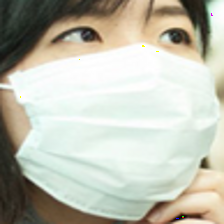

Labels = [1 0 0]


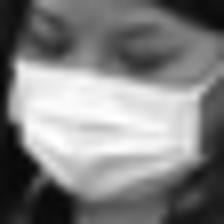

Labels = [1 0 0]


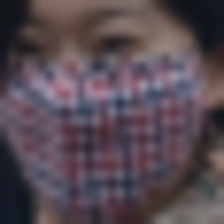

Labels = [1 0 0]


In [ ]:
offset = 4
for image, label in iter(files_ds.take(3)):
    arr = (image.numpy() * 255).astype(np.uint8)
    img = Image.fromarray(arr, mode="RGB")
    img.show()
    print(f"Labels = {label.numpy()}")
    #print(arr)

In [ ]:
files_ds

<MapDataset shapes: ((224, 224, 3), (3,)), types: (tf.float32, tf.int64)>

In [ ]:
len(files_ds)

29288

## Train Test Split

In [ ]:
def is_test(a, b):
    
    return a % 7 < 2      # 2/7 of data goes to test set (the half of it goes then to validation)

def is_train(a, b):
    return not is_test(a, b)  # all the rest goes to train set (5/7 of the whole set)

def is_val(a, b):
    return a % 2 == 0         # from test set every 2nd data goes to validation set (1/7 of the whole set)

def is_test2(a, b):
    return not is_val(a, b)   # all the rest goes to final test set (1/7 of the whole set)

remove_index = lambda a,b: b

test_dataset = files_ds.enumerate() \
                    .filter(is_test) \
                    .map(remove_index)

# now test_dataset = 2/7 of whole

train_dataset = files_ds.enumerate() \
                    .filter(is_train) \
                    .map(remove_index)

# now train_dataset = 5/7 of whole

val_dataset   = test_dataset.enumerate() \
                    .filter(is_val) \
                    .map(remove_index)

# now val_dataset = 1/7 of whole

test_dataset = test_dataset.enumerate() \
                    .filter(is_test2) \
                    .map(remove_index)

# now test_dataset = 1/7 of whole


In [ ]:
train_dataset

<MapDataset shapes: ((224, 224, 3), (3,)), types: (tf.float32, tf.int64)>

In [ ]:
from tqdm import tqdm

In [ ]:
count = 0

for _ in tqdm(train_dataset):
    count+=1
    
train_ds_length = count

20920it [00:34, 601.41it/s]


In [ ]:
count = 0

for _ in tqdm(test_dataset):
    count+=1

test_ds_length = count

4184it [00:12, 342.21it/s]


In [ ]:
count = 0

for _ in tqdm(val_dataset):
    count+=1

val_ds_length = count

4184it [00:12, 341.49it/s]


# Modeling

In [ ]:
# use the pretrained model vgg16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# load pretrained model without classifier layers
#model0 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# add new classifier layers
# here we can define at which layer of the pretrained model we attach our layers
#cnn = Conv2D(filters=10, kernel_size=(3,3), padding="same", activation="relu")(model0.layers[-3].output)
#flat1 = Flatten()(cnn)
#class1 = Dense(1024, activation='relu')(flat1)
#output = Dense(3, activation='softmax')(class1) # triple class classification
# define new model
#model1 = Model(inputs=model0.inputs, outputs=output)
# summarize
#model1.summary()

In [ ]:
# use the pretrained model vgg16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# load pretrained model without classifier layers
model0 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# set the layers of the pretrained model to not trainable!!!
for layer in model0.layers:
	layer.trainable = False

# add new classifier layers
# here we can define at which layer of the pretrained model we attach our layers
cnn = Conv2D(filters=10, kernel_size=(3,3), padding="same", activation="relu")(model0.layers[-3].output)
flat1 = Flatten()(cnn)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1) # triple class classification
# define new model
model1 = Model(inputs=model0.inputs, outputs=output)
# summarize
model1.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
d12 = model1.get_layer(name="dense_12")
d13 = model1.get_layer(name="dense_13")

d12_config = d10.get_config()
d13_config = d11.get_config()

ValueError: No such layer: dense_12.

In [ ]:
model0.inputs, model0.layers[-3]

([<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>],
 <keras.layers.convolutional.Conv2D at 0x7f26fc0835c0>)

In [ ]:
# compile the model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import AUC, CategoricalAccuracy, Precision


opt = Adam(learning_rate=0.001)
model1.compile(optimizer=opt, loss=categorical_crossentropy, metrics=[CategoricalAccuracy(), Precision(), 'AUC'])

In [ ]:
epochs=10
batch_size=8
val_batch_size = 8

history = model1.fit(
                    train_dataset.repeat().batch(batch_size),
                    epochs=epochs,
                    verbose=1,
                    steps_per_epoch=(train_ds_length // batch_size),
                    #batch_size=None, # this is not to set in case of tf.datasets
                    callbacks=None,
                    validation_data = val_dataset.batch(val_batch_size),  #,  or this is not good?
                    validation_steps=(val_ds_length // val_batch_size),
                    workers=1,
                    use_multiprocessing=True)

model1.save("model1.h5")

Epoch 1/10
2615/2615 [==============================] - 372s 140ms/step - loss: 0.4670 - categorical_accuracy: 0.8142 - precision: 0.8250 - auc: 0.9423 - val_loss: 0.3755 - val_categorical_accuracy: 0.8466 - val_precision: 0.8532 - val_auc: 0.9627
Epoch 2/10
2615/2615 [==============================] - 365s 140ms/step - loss: 0.2947 - categorical_accuracy: 0.8852 - precision: 0.8937 - auc: 0.9763 - val_loss: 0.2607 - val_categorical_accuracy: 0.9099 - val_precision: 0.9152 - val_auc: 0.9820
Epoch 3/10
2615/2615 [==============================] - 367s 140ms/step - loss: 0.1956 - categorical_accuracy: 0.9269 - precision: 0.9335 - auc: 0.9890 - val_loss: 0.2677 - val_categorical_accuracy: 0.9214 - val_precision: 0.9224 - val_auc: 0.9826
Epoch 4/10
2615/2615 [==============================] - 365s 140ms/step - loss: 0.1506 - categorical_accuracy: 0.9441 - precision: 0.9479 - auc: 0.9930 - val_loss: 0.3272 - val_categorical_accuracy: 0.9245 - val_precision: 0.9255 - val_auc: 0.9795
Epoch 5/

after 10 epochs we got promising values. Let' see the evaluation and the prediction on the test set

In [ ]:
model1.evaluate(test_dataset.batch(8), steps=(test_ds_length // 8))

523/523 [==============================] - 59s 112ms/step - loss: 0.1639 - categorical_accuracy: 0.9563 - precision: 0.9565 - auc: 0.9914


[0.16389767825603485, 0.956261932849884, 0.956469714641571, 0.9913716912269592]

In [ ]:
yhat = model1.predict(test_dataset.batch(8), steps=(test_ds_length // 8))

In [ ]:
yhat[0:15]

array([[1.0000000e+00, 1.1186648e-32, 3.6885709e-33],
       [1.0000000e+00, 6.8487711e-21, 9.6922963e-16],
       [2.4042428e-12, 1.6844298e-15, 1.0000000e+00],
       [9.9996531e-01, 5.6867395e-09, 3.4702192e-05],
       [9.9941468e-01, 1.5838126e-04, 4.2705151e-04],
       [9.9999940e-01, 2.0165454e-13, 5.7831704e-07],
       [1.0000000e+00, 1.0043751e-12, 4.1110987e-08],
       [9.9999964e-01, 3.7981508e-15, 3.2801870e-07],
       [9.9273491e-01, 1.1238323e-05, 7.2538140e-03],
       [1.0000000e+00, 9.3008574e-22, 7.5524760e-26],
       [1.0000000e+00, 7.9312746e-12, 3.1960854e-14],
       [7.3989707e-01, 2.3409843e-01, 2.6004478e-02],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [9.9999619e-01, 3.8209705e-06, 1.6824667e-09],
       [1.0000000e+00, 2.7148670e-19, 3.1724015e-20]], dtype=float32)

In [ ]:
for item in iter(test_dataset.batch(8).take(1)):
    print(item)

(<tf.Tensor: shape=(8, 224, 224, 3), dtype=float32, numpy=
array([[[[0.11560631, 0.11560631, 0.11560631],
         [0.11493484, 0.11493484, 0.11493484],
         [0.11385141, 0.11385141, 0.11385141],
         ...,
         [0.07177444, 0.07177444, 0.07177444],
         [0.07187638, 0.07187638, 0.07187638],
         [0.07193954, 0.07193954, 0.07193954]],

        [[0.11535073, 0.11535073, 0.11535073],
         [0.11468344, 0.11468344, 0.11468344],
         [0.11360675, 0.11360675, 0.11360675],
         ...,
         [0.07162777, 0.07162777, 0.07162777],
         [0.07173194, 0.07173194, 0.07173194],
         [0.0717965 , 0.0717965 , 0.0717965 ]],

        [[0.11493785, 0.11493785, 0.11493785],
         [0.1142773 , 0.1142773 , 0.1142773 ],
         [0.11321149, 0.11321149, 0.11321149],
         ...,
         [0.07139079, 0.07139079, 0.07139079],
         [0.0714986 , 0.0714986 , 0.0714986 ],
         [0.0715654 , 0.0715654 , 0.0715654 ]],

        ...,

        [[0.08061676, 0.08061676,

In [ ]:
def dataset_to_numpy(ds):
    """
    Convert tensorflow dataset to numpy arrays
    """
    # images = []
    labels = []

    # Iterate over a dataset
    for i, (image, label) in enumerate(ds.as_numpy_iterator()):
        # images.append(image)
        labels.append(label)

    #for i, img in enumerate(images):
    #    if i < 3:
    #        print(img.shape, labels[i])

    return labels

In [ ]:
y_true = dataset_to_numpy(test_dataset)
y_true = np.asarray(y_true)

In [ ]:
type(y_true), type(yhat)

(numpy.ndarray, numpy.ndarray)

In [ ]:
simple_hat = (yhat > 0.5).astype(int)
simple_hat[100:115], y_true[100:115]

(array([[0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1]]),
 array([[0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1]]))

In [ ]:
labels_list = ["with_mask", "mask_weared_incorrect", "without_mask"]

In [ ]:
print(classification_report(y_true, simple_hat, labels=[x for x in range(3)], target_names=labels_list, digits=2))

                       precision    recall  f1-score   support

            with_mask       0.98      0.97      0.97      3321
mask_weared_incorrect       0.88      0.76      0.82       144
         without_mask       0.86      0.95      0.90       719

            micro avg       0.96      0.96      0.96      4184
            macro avg       0.91      0.89      0.90      4184
         weighted avg       0.96      0.96      0.96      4184
          samples avg       0.96      0.96      0.96      4184

/shared-libs/python3.6/py/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Post-processing analysis

We found that we're getting identical prediction results from our model.

After research and consulting the results with Patricia we set up followng course of action:
 * Change the pre-processing
   - incorporate the pre-processing function for VGG16   
   - drop the tiniest images under 5% percentile
   - do a train test split
   - perform pre-processing (not the augmentation) on train and test set
   - find a way how to identify size over 15% percentile images from train set
   - do augmentation on this selection
      - avoid channel reduction
      - add more rotation, gamma correction, vertical mirror (there already), image shift (H + V) + parameters variations
   - do train - validation split
 * Change model:
   - make the VGG part untrainable (trainable = False)  --- DONE, just by this the model produces good results 
   - increase the amount of filters on first Conv2D layer (our attachment)
   - add couple more FC layers
   - make sure that weights are explicitly configured (weight='imagenet')
   - increase epochs for training (10, 50, 100, 250)

AttributeError: module 'matplotlib.pyplot' has no attribute 'bar_label'

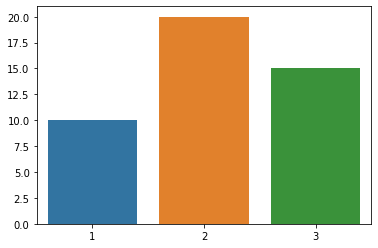

In [ ]:
ax = sns.barplot(x=[1,2,3], y=[10, 20, 15])
plt.bar_label([1,2,3])

In [ ]:
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.3.4


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dab6003c-ddb5-4c9e-be8b-1f1c983fb6d1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>